In [1]:
import numpy as np
import pandas as pd
import napari
import os
import matplotlib.pyplot as plt
from skimage import io
from mouselight_code.src.benchmarking_params import brain_offsets, vol_offsets, scales, type_to_date
from mouselight_code.src import read_swc
from brainlit.utils.swc import df_to_graph, graph_to_paths
from pathlib import Path
from sklearn.metrics import pairwise_distances_argmin_min

C:\Users\frede\anaconda3\envs\brainlit3.7\lib\site-packages\napari\__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)
C:\Users\frede\anaconda3\envs\brainlit3.7\lib\site-packages\python_jsonschema_objects\__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


## Loading the Vaa3D plugin wrapper

- Download and install Vaa3D 3.447: https://github.com/Vaa3D/release/releases/tag/v3.447
- Install the pyVaa3d wrapper in the Python environment: https://github.com/ajkswamy/pyVaa3d
- When running this the first time, you will be prompted for the path to `vaa3d_msvc.exe` (Windows), `vaa3d64.app` (Mac), or `start_vaa3d.sh` (Linux).

In [2]:
from pyVaa3d.vaa3dWrapper import runVaa3dPlugin

Working Vaa3d executable found at C:\Users\frede\Documents\Y4\Y4_NDD\Vaa3D_V3.447_Windows_MSVC_64bit\Vaa3D_V3.447_Windows_MSVC_64bit\vaa3d_msvc.exe!


## APP2 output loading

The following function is for loading the APP2 .swc output files as a list of labels.

In [3]:
# For unpacking the APP2 output .swc files as a list of labels
def app2_swc_unpack(fname):
    """Reads in the results swc file and converts it to a list of (x,y,z)
       coordinates corresponding to labels
    """

    # check input
    file = open(fname, "r")
    skip_header = True
    readable = True
    header_length = -1
    while skip_header:
        line = file.readline().split()
        if line != []:
            if line[0][0] != "#":
                #line = file.readline().split()
                skip_header = False
        else:
            readable = False
            skip_header = False
            
        header_length += 1
    # read coordinates
    if readable:
        df = pd.read_table(
            fname,
            names=["n", "type", "x", "y", "z", "radius", "parent"],
            skiprows=header_length,
            sep="\s+"
        )
    else:
        return None
     
    # NOTE: The read-in order is [z,y,x] since the image is flipped.
    labels = np.array(df[["z","y","x"]])
    return labels

## Significant Spatial Distance Metric

This is the same function as in https://github.com/neurodata/mouselight_code/blob/tom/swc_evaluate/mouselight_code/src/swc_eval.py

In [4]:
def ssd(pts1, pts2):
    """Compute significant spatial distance metric between two traces as defined in APP1.
    Args:
        pts1 (np.array): array containing coordinates of points of trace 1. shape: npoints x ndims
        pts2 (np.array): array containing coordinates of points of trace 1. shape: npoints x ndims
    Returns:
        [float]: significant spatial distance as defined by APP1
    """
    _, dists1 = pairwise_distances_argmin_min(pts1, pts2)
    dists1 = dists1[dists1 >= 2]
    _, dists2 = pairwise_distances_argmin_min(pts2, pts1)
    dists2 = dists2[dists2 >= 2]
    dists = np.concatenate([dists1, dists2])
    ssd = np.mean(dists)
    return ssd

## Running APP2

Using the `runVaa3dPlugin` function, batch testing of APP2 can be performed. Currently, the following script is set up to only run in `test_X-gfp.tif` files. APP2 will dump the resulting `.swc` files in the same directory as the inputs. If preferable, one needs to manually move these files into a dedicated output folder.

Note that this will take roughly 45-60 mins to run for 25 images.

In [ ]:
directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
for n in range(1,26):
    fname = 'test_' + str(n) + '-gfp.tif'
    img_name = os.path.join(directory, fname)
    img = io.imread(img_name)

    # NOTE: This will autodump files into the dataset folder, since app2
    # is set up to dump in the source folder.
    print(f"Running APP2 on image {fname}.")
    runVaa3dPlugin(inFile=img_name, pluginName="Vaa3D_Neuron2",
                   funcName="app2")

print(f"APP2 Done. Please check {directory} for outputs.")

## Loading the results

Vaa3D will output 2 `.swc` files, one with a `_ini.swc` extension and one with an `_xAB_yCD_zEF.swc` extension. The latter is the pruned output that corresponds to the final result, where the `x, y, z` portion of the extension is the location of the soma or root of the reconstruction.

The results are stored in a dictionary, where the key is the original input file name without a `.tif` extension.

In [6]:
directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'

test_results = {}

for f in os.listdir(directory):
    if f.endswith("app2.swc"):
        test_results[f.split(sep='.')[0]] = app2_swc_unpack(os.path.join(directory, f))

# List of the input data files without .tif extension
fnames = list(test_results.keys())

## Computing SSD, Comparing with ground truth labels

APP2 runs rather poorly on many of the testing images, producing traces that are difficult to compare to the input data. As such, one will need to manually look through the APP2-produced reconstructions and determine whether or not they are qualitatively reasonable.

In [14]:
# --- Manually Preview the Reconstruction ---
# When manually viewing the reconstructions in napari,
# Jupyter notebook can't display a napari viewer result.
# To see result, please run in a local Python environment.
raw_directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
fnames = list(test_results.keys())
select_file = fnames[13]
print("File viewed: ", select_file)
img_name = select_file+".tif"

img = io.imread(os.path.join(raw_directory, img_name))
img_labels = test_results[select_file]

with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(img)
    viewer.add_points(img_labels, size=1, opacity=0.5, face_color='yellow',edge_color='red')

File viewed:  test_21-gfp


### Loading the ground truth labels

In [42]:
# Target files for inputs.
target_files = fnames #[fnames[6], fnames[7], fnames[13]]

# Directory of the input data
raw_directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
im_dir = Path(raw_directory)
gfp_files = list(im_dir.glob("**/*-gfp.tif"))
# Path of the manual ground truth data
swc_base_path = im_dir / "Manual-GT"

gt_labels = {}

# (Loading code courtesy of Tommy.)
# for every image
for im_num, im_path in enumerate(gfp_files):
    
    f = im_path.parts[-1][:-8].split("_")
    image = f[0]

    date = type_to_date[image]
    num = int(f[1])
    img_name = image + "_" + str(num) + "-gfp"
    
    # Skip the file if it's not of interest
    if img_name not in target_files:
        continue
    
    # More file reading
    scale = scales[date]
    brain_offset = brain_offsets[date]

    vol_offset = vol_offsets[date][num]
    im_offset = np.add(brain_offset, vol_offset)
    
    # Parse the proper directory
    lower = int(np.floor((num - 1) / 5) * 5 + 1)
    upper = int(np.floor((num - 1) / 5) * 5 + 5)
    dir1 = date + "_" + image + "_" + str(lower) + "-" + str(upper)
    dir2 = date + "_" + image + "_" + str(num)
    swc_path = swc_base_path / dir1 / dir2
    
    # Read swcs
    swc_files = list(swc_path.glob("**/*.swc"))
    #im = io.imread(im_path, plugin="tifffile")
    #print(f"Image shape: {im.shape}")
    path_total = []
    for swc_num, swc in enumerate(swc_files):
        if "cube" in swc.parts[-1]:
            # skip the bounding box swc
            continue

        df, swc_offset, _, _, _ = read_swc.read_swc(swc)

        #compute the offset of the swc relative to the image
        offset_diff = np.subtract(swc_offset, im_offset)
        G = df_to_graph(df)

        paths = graph_to_paths(G)
        # for every path in that swc
        for path_num, p in enumerate(paths):
            #convert from spatial coordinates to voxel coordinates
            pvox = (p + offset_diff) / (scale) * 1000
            
            # Swap the columns to orient properly
            pvox[:, [2, 0]] = pvox[:, [0, 2]] 
            path_total.extend(pvox)
    gt_labels[img_name] = path_total

### Compute SSD metric

NOTE: The SSD metric is set to None if the APP2 reconstruction produced an empty trace. 

In [21]:
SSD = {}
for img_name in list(gt_labels.keys()):
    if test_results[img_name] is None:
        SSD[img_name] = None
        continue
    SSD[img_name] = ssd(test_results[img_name], gt_labels[img_name])

### View the comparison

The following code will have ground truth in Green and the APP2 labels in Yellow/Red.

In [47]:
image_of_interest = "test_17-gfp"#target_files[6]
img = io.imread(os.path.join(raw_directory, image_of_interest + ".tif"))
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(img)
    viewer.add_points(gt_labels[image_of_interest], size=0.8, opacity=0.5, face_color='green',edge_color='green')
    viewer.add_points(test_results[image_of_interest], size=0.8, opacity=0.5, face_color='yellow',edge_color='red')     
print(f"SSD of {image_of_interest}: {SSD[image_of_interest]}")

SSD of test_17-gfp: 45.41820739310418


Note: There are a few problems with some of the images. test_9-gfp, test_10-gfp, and test_24-gfp have some ground truth misalignment issues, so these will be omitted.

Text(0, 0.5, 'Significant Spatial Distance (SSD)')

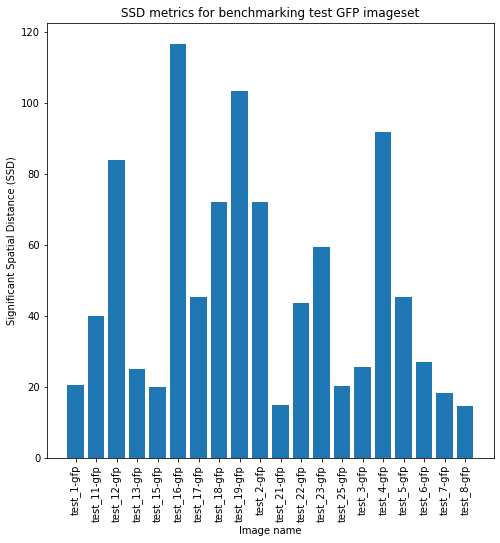

In [48]:
keys = []
metrics = []
items_to_drop = ["test_9-gfp", "test_10-gfp", "test_24-gfp"]
for i in list(SSD.keys()):
    if i in items_to_drop:
        continue
    if SSD[i] != None:
        keys.append(i)
        metrics.append(SSD[i])

plt.figure(figsize=(8,8))
plt.bar(range(len(metrics)),metrics)
plt.xticks(np.arange(len(keys)), keys, rotation='vertical')
plt.title("SSD metrics for benchmarking test GFP imageset")
plt.xlabel("Image name")
plt.ylabel("Significant Spatial Distance (SSD)")